<a href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

In [2]:
import vista
from vista.utils import logging
logging.setLevel(logging.ERROR)
import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl
import tensorflow as tf
import os


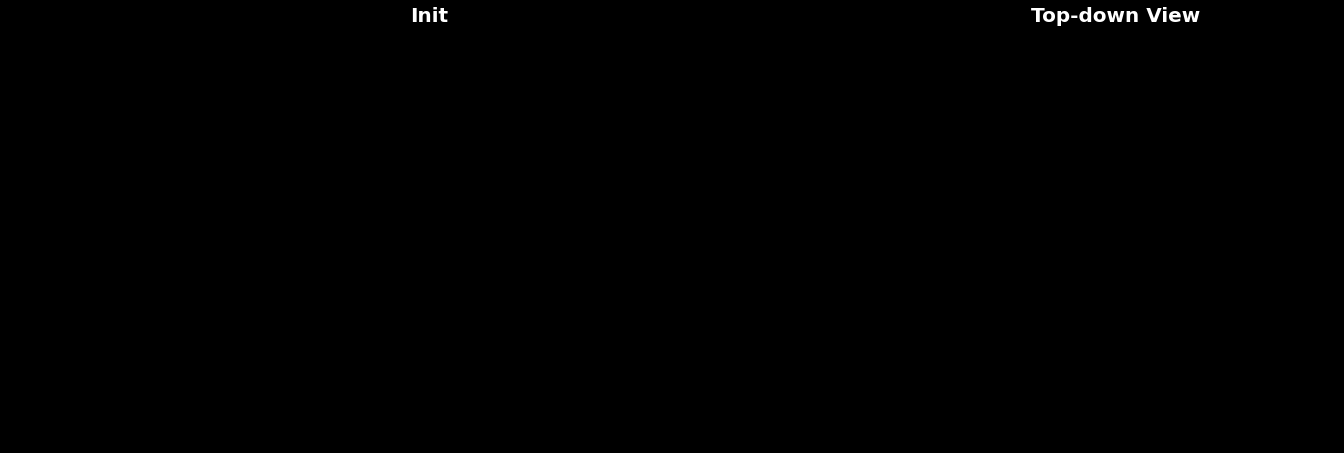

In [3]:
# creat an environemnt in vista
#  display.render() use to render 
#  reset()          restart

trace_root = "./vista_traces"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]

# Create a virtual world with VISTA, the world is defined by a series of data traces
world = vista.World(trace_path, trace_config={'road_width': 4})

# Create a car in our virtual world. The car will be able to step and take different 
#   control actions. As the car moves, its sensors will simulate any changes it environment
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })

#create camera on the car for synthesizing the sensor data that we can use to train
camera = car.spawn_camera(config={'size': (200, 320)})

# Define a rendering display so we can visualize the simulated car camera stream and also 
#   get see its physical location with respect to the road in its environment. 
display = vista.Display(world, display_config={"gui_scale": 2, "vis_full_frame": False})

# Define a simple helper function that allows us to reset VISTA and the rendering display
def vista_reset():
    world.reset()
    display.reset()
vista_reset()

## 3.8 Preparing to learn a control policy: data preprocessing

So, hopefully you saw that the random control policy was, indeed, not very robust. Yikes. Our overall goal in this lab is to build a self-driving agent using a neural network controller trained entirely in the simulator VISTA. This means that the data used to train and test the self-driving agent will be supplied by VISTA. As a step towards this, we will do some data preprocessing to make it easier for the network to learn from these visual data.

Previously we rendered the data with a display as a quick check that the environment was working properly. For training the agent, we will directly access the car's observations, extract Regions Of Interest (ROI) from those observations, crop them out, and use these crops as training data for our self-driving agent controller. Observe both the full observation and the extracted ROI.

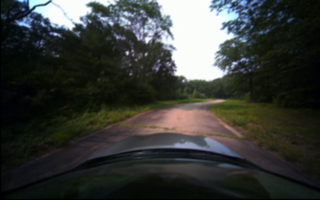

In [6]:
#!pip install google-colab
from google.colab.patches import cv2_imshow

# Directly access the raw sensor observations of the simulated car
vista_reset()
full_obs = car.observations[camera.name]
cv2_imshow(full_obs)

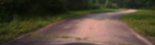

In [7]:
## ROIs ##

# Crop a smaller region of interest (ROI). This is necessary because: 
#   1. The full observation will have distortions on the edge as the car deviates from the human
#   2. A smaller image of the environment will be easier for our model to learn from
region_of_interest = camera.camera_param.get_roi()
i1, j1, i2, j2 = region_of_interest
cropped_obs = full_obs[i1:i2, j1:j2]
cv2_imshow(cropped_obs)

In [8]:
## Data preprocessing functions ##
def preprocess(full_obs):
    # Extract ROI
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    
    # Rescale to [0, 1]
    obs = obs / 255.
    return obs
# grab the car's current observation and then preprocess it
def grab_and_preprocess_obs(car):
    full_obs = car.observations[camera.name]
    obs = preprocess(full_obs)
    return obs

In [9]:
### Define the self-driving agent ###

# Functionally define layers for convenience
# All convolutional layers will have ReLu activation
act = tf.keras.activations.swish
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='valid', activation=act)
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Defines a CNN for the self-driving agent
def create_driving_model():
    model = tf.keras.models.Sequential([
        # standard Convolutional layers
        Conv2D(filters=32, kernel_size=5, strides=2),
        Conv2D(filters=48, kernel_size=5, strides=2), # 
        Conv2D(filters=64, kernel_size=3, strides=2), # TODO
        Conv2D(filters=64, kernel_size=3, strides=2), # TODO
        Flatten(),
        # Fully connected layer and output
        Dense(units=128, activation=act),
        # units =2 mean and variance
        Dense(units=2, activation=None) # TODO

    ])
    return model

driving_model = create_driving_model()

In [15]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else: 
            prediction = model(observations)

        #compute the loss
        loss = loss_function(prediction, actions, discounted_rewards) # TODO

    '''TODO: run backpropagation to minimize the loss using the tape.gradient method. 
             Unlike supervised learning, RL is *extremely* noisy, so you will benefit 
             from additionally clipping your gradients to avoid falling into 
             dangerous local minima. After computing your gradients try also clipping
             by a global normalizer. Try different clipping values, usually clipping 
             between 0.5 and 5 provides reasonable results. '''
    #minize the loss using the tape.gradient method
    grads = tape.gradient(loss, model.trainable_variables) 
    #clipping gradient to avoid falling into local minima #t * clip_norm / l2norm(t)
    grads, _ = tf.clip_by_global_norm(grads, 2)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [11]:
## The self-driving learning algorithm ##

# hyperparameters
max_curvature = 1/8. 
max_std = 0.1 

def run_driving_model(image):
    # Arguments:
    #   image: an input image
    # Returns:
    #   pred_dist: predicted distribution of control actions 
    single_image_input = tf.rank(image) == 3  # missing 4th batch dimension
    if single_image_input:
        image = tf.expand_dims(image, axis=0)

    #get the prediction of the model given the current observation.
    distribution = driving_model(image)

    mu, logsigma = tf.split(distribution, 2, axis=1)
    mu = max_curvature * tf.tanh(mu) # conversion
    sigma = max_std * tf.sigmoid(logsigma) + 0.005 # conversion
    
    # define the predicted distribution of curvature, given the predicted mu and sigma
    pred_dist = tfp.distributions.Normal(mu, sigma)
    return pred_dist

# compute the loss function check tfp.distributions.Normal
def compute_driving_loss(dist, actions, rewards):
    #-log(p(at|st))
    neg_logprob = -1 * dist.log_prob(actions)
   
    #loss = -log(p(at|st)) * R
    loss = tf.reduce_mean( neg_logprob * rewards )
    return loss


In [13]:
#define the memory

class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        self.actions.append(new_action) 
        self.rewards.append(new_reward) 
  

    def __len__(self):
        return len(self.actions)


In [14]:
## Training parameters and initialization ##
## Re-run this cell to restart training from scratch ##

''' TODO: Learning rate and optimizer '''
learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate driving agent
vista_reset()
driving_model = create_driving_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

# instantiate Memory buffer
memory = Memory()

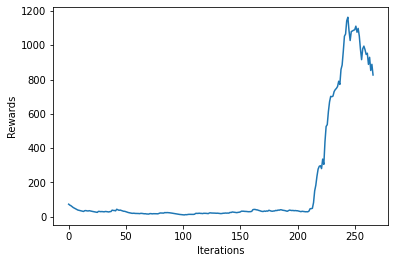

KeyboardInterrupt: 

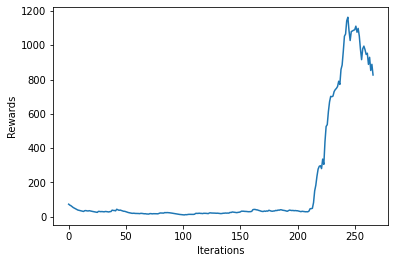

In [30]:
## Driving training! Main training block. ##

max_batch_size = 300
max_reward = float('-inf') # keep track of the maximum reward acheived during training
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500)

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    vista_reset()
    memory.clear()
    observation = grab_and_preprocess_obs(car)

    while True:
        
        #use the dnn to compute the policy distribution
        curvature_dist = run_driving_model(observation)
        
        #sample one action form the policy distribution
        curvature_action = curvature_dist.sample()[0,0]
        # curvature_action = '''TODO'''
        
        # take the action and have a new observation
        vista_step(curvature_action)
        observation = grab_and_preprocess_obs(car)

        #reward function 1 for not crash 0 for crash
        reward = 1.0 if not check_crash(car) else 0.0
        
        # add the trajectory to the memory
        memory.add_to_memory(observation, curvature_action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if reward == 0.0:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            # execute training step 
            batch_size = min(len(memory), max_batch_size)
            i = np.random.choice(len(memory), batch_size, replace=False)
            train_step(driving_model, compute_driving_loss, optimizer, 
                               observations=np.array(memory.observations)[i],
                               actions=np.array(memory.actions)[i],
                               discounted_rewards = discount_rewards(memory.rewards)[i], 
                               custom_fwd_fn=run_driving_model)            
            # reset the memory
            memory.clear()
            break

In [35]:
#save the model
driving_model.save("driving_model_800")

INFO:tensorflow:Assets written to: driving_model_800/assets


In [ ]:
## Evaluation block!##

i_step = 0
num_episodes = 1
num_reset = 5
stream = VideoStream()
for i_episode in range(num_episodes):
    
    # Restart the environment
    vista_reset()
    observation = grab_and_preprocess_obs(car)
    
    print("rolling out in env")
    episode_step = 0
    while not check_crash(car)and episode_step < 1000:
        # using our observation, choose an action and take it in the environment
        curvature_dist = run_driving_model(observation)
        curvature = curvature_dist.mean()[0,0]

        # Step the simulated car with the same action
        vista_step(curvature)
        observation = grab_and_preprocess_obs(car)

        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i_step)
        i_step += 1
        episode_step += 1
        
    for _ in range(num_reset):
        stream.write(np.zeros_like(vis_img), index=i_step)
        i_step += 1
        
print(f"Average reward: {(i_step - (num_reset*num_episodes)) / num_episodes}")

print("Saving trajectory with trained policy...")
stream.save("trained_policy.mp4")
mdl.lab3.play_video("trained_policy.mp4")

rolling out in env


/usr/local/anaconda3/envs/tf/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
